# Lab 2: Cats vs Dogs

**Deadline**: May 28, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Tinglin (Francis) Duan

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1O4GMvkuQG0HmyefCQ5RIn-ZT8nVP73kJ?usp=sharing

In [3]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [4]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=0, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=0, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=0, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    print("Data: {}, Graph: Epoch VS Error".format(path))
    
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    print("Data: {}, Graph: Epoch VS Loss".format(path))

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [47]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Files already downloaded and verified
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

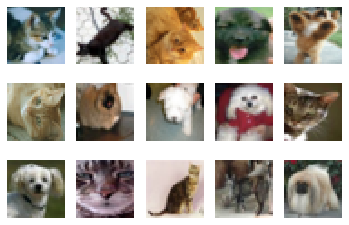

In [48]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [49]:
print("Training examples for the combined cat & dog classes: {}".format(len(train_loader)))
print("Validation examples for the combined cat & dog classes: {}".format(len(val_loader)))
print("Test examples for the combined cat & dog classes: {}".format(len(test_loader)))

Training examples for the combined cat & dog classes: 8000
Validation examples for the combined cat & dog classes: 2000
Test examples for the combined cat & dog classes: 2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

- By adjusting our model based on the training set loss/error, we can overfit our model to the training set. It is better to gauge the performance of our model by feeding it never seen data from the validation set. 
- We can get an unbiased understanding of our model's skill by evaluating the performance of the validation set compared to the training set.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [5]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [6]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [7]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

## Explanation

Total number of parameters in a network is the sum of all the elements in each layer(tensor). Below I iterate over each network and sum the total elements in each tensor by multiplying the size elements together.

In [25]:
total_param_list = list()
network_list = [small_net, large_net]

for network in network_list:
    total_params = 0 # Store the total elements of each network
    
    for param in network.parameters():
        tensor_total = 0 # Store the total elements of each tensor
    
        for num in param.shape:
            if tensor_total:
                tensor_total *= num
            else:
                tensor_total = num
        
        total_params += tensor_total
    
    total_param_list.append(total_params)
    
    
print("Total parameters in small_net: {}".format(total_param_list[0]))
print("Total parameters in large_net: {}".format(total_param_list[-1]))
    

Total parameters in small_net: 386
Total parameters in large_net: 9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

## NOTE: I included a parameter called trial_name to create a sub directory for the files that are written for each iteration of the train_net function call.

In [10]:
import os

def train_net(net, trial_name = None, batch_size=64, learning_rate=0.01, num_epochs=30):
    
    # If a trial_name is defined, a directory will be created to store all the log files.
    if trial_name and not os.path.exists('./{}'.format(trial_name)):
        os.mkdir('./{}'.format(trial_name))
        
    
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), "./{}/{}".format(trial_name, model_path)) if trial_name else torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    if trial_name:
        np.savetxt("./{}/{}_train_err.csv".format(trial_name, model_path), train_err)
        np.savetxt("./{}/{}_train_loss.csv".format(trial_name, model_path), train_loss)
        np.savetxt("./{}/{}_val_err.csv".format(trial_name, model_path), val_err)
        np.savetxt("./{}/{}_val_loss.csv".format(trial_name, model_path), val_loss)
    else:
        np.savetxt("{}_train_err.csv".format(model_path), train_err)
        np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
        np.savetxt("{}_val_err.csv".format(model_path), val_err)
        np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

Default values are:
- batch_size: 64
- learning_rate: 0.01
- num_epochs: 30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [27]:
# Call the train_net function with the following parameter: net=small_net, num_epochs=5
#NOTE: If you're confused why there is a trial_name parameter, read explanation above.

train_net(small_net, trial_name="test", num_epochs=5)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.418375, Train loss: 0.6704228835105897 |Validation err: 0.3725, Validation loss: 0.6553282551467419
Epoch 2: Train err: 0.36175, Train loss: 0.6442333178520203 |Validation err: 0.3845, Validation loss: 0.6532739866524935
Epoch 3: Train err: 0.34825, Train loss: 0.6302793879508972 |Validation err: 0.3355, Validation loss: 0.6202500350773335
Epoch 4: Train err: 0.335875, Train loss: 0.6170277276039123 |Validation err: 0.3375, Validation loss: 0.6170362215489149
Epoch 5: Train err: 0.331625, Train loss: 0.6116786141395569 |Validation err: 0.3315, Validation loss: 0.6137247402220964
Finished Training
Total time elapsed: 10.03 seconds


## Explanation on the files written to disk

Keep a log of the current model's checkpoint at each iteration of epoch (we have 5 files for each epoch starting at index 0):
- model_small_bs64_lr0.01_epoch0
- model_small_bs64_lr0.01_epoch1
- model_small_bs64_lr0.01_epoch2
- model_small_bs64_lr0.01_epoch3
- model_small_bs64_lr0.01_epoch4

We also keep a log of training/validation set error/loss values for each epoch in a list, and then we write the contents of the lists to individual csv values. This would be written for each network that we pass in.
- model_small_bs64_lr0.01_epoch4_train_err.csv
- model_small_bs64_lr0.01_epoch4_train_loss.csv
- model_small_bs64_lr0.01_epoch4_val_err.csv
- model_small_bs64_lr0.01_epoch4_val_loss.csv

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [28]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google'

In [29]:
print("Training small_net:")
print("NOTE: Log files can be found in the ./partd-small_net drectory. \n")
train_net(small_net, trial_name="partd-small_net")

print("Training large_net:")
print("NOTE: Log files can be found in the ./partd-large_net drectory. \n")
train_net(large_net, trial_name="partd-large_net")

Training small_net:
NOTE: Log files can be found in the ./partd-small_net drectory. 

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.324625, Train loss: 0.6044533605575562 |Validation err: 0.3355, Validation loss: 0.6165376491844654
Epoch 2: Train err: 0.316125, Train loss: 0.6004518358707428 |Validation err: 0.3585, Validation loss: 0.6426437422633171
Epoch 3: Train err: 0.31375, Train loss: 0.5964802887439727 |Validation err: 0.3215, Validation loss: 0.6010604994371533
Epoch 4: Train err: 0.3155, Train loss: 0.587684741973877 |Validation err: 0.3155, Validation loss: 0.602411326020956
Epoch 5: Train err: 0.30725, Train loss: 0.5854557240009308 |Validation err: 0.3115, Validation loss: 0.6001594997942448
Epoch 6: Train err: 0.30125, Train loss: 0.5791056852340698 |Validation err: 0.316, Validation loss: 0.5976096466183662
Epoch 7: Train err: 0.30075, Train loss: 0.5754583125114441 |Validation err: 0.321, Validation loss: 0.59924591332

## Explanation on the total time elapsed when training each network

- small_net: 58.09 seconds
- large_net: 101.35 seconds


The larger network (large_net) took longer to train and that makes sense. The larger network consists of additional computation steps (ex. large_net has two convolution layers compared to small_net which has one convolution layer), which adds to the time to process the datasets.



### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

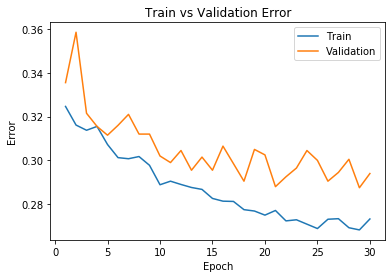

Data: ./partd-small_net/model_small_bs64_lr0.01_epoch29, Graph: Epoch VS Error


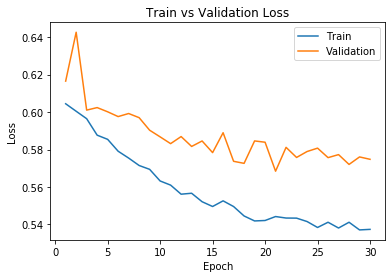

Data: ./partd-small_net/model_small_bs64_lr0.01_epoch29, Graph: Epoch VS Loss


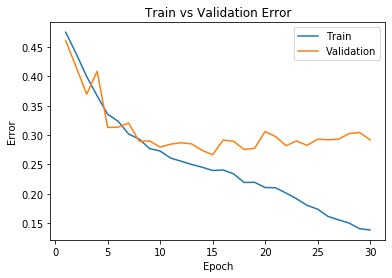

Data: ./partd-large_net/model_large_bs64_lr0.01_epoch29, Graph: Epoch VS Error


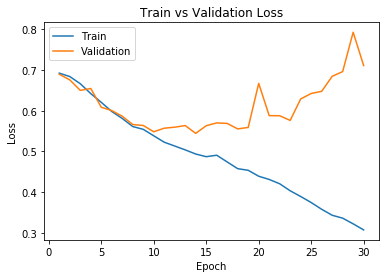

Data: ./partd-large_net/model_large_bs64_lr0.01_epoch29, Graph: Epoch VS Loss


In [5]:
#model_path = get_model_name("small", batch_size=??, learning_rate=??, epoch=29)
## NOTE: I'm not going to use the helper function get_model_name, because I changed the formatting of the file save locations.

# Plot the small_net data:
plot_training_curve("./partd-small_net/model_small_bs64_lr0.01_epoch29")

# Plot the large_net data
plot_training_curve("./partd-large_net/model_large_bs64_lr0.01_epoch29")

# NOTE: There's a bug in the code, so none of the texts show up in any of the graphs

To mitigate this, I generated the charts locally and saved them as a .png file so that I can look at them. 

I changed the **plot_training_curve** function to print out what graphs it was rendering.

**UPDATE:** When I restarted the kernel (Kernel -> Restart & Run All), the text magically showed up. But I'm going to leave the debug print statements.

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In both model architectures, we naturally expect the error to drop for larger epochs. This is an indication of the models' tendency to overfit to the training with increased repetition and exposure to the training data. 

The small_net had fewer layers than the large_net architecture, and that means that there are fewer weights to tune. As a result, you can see that there is a sharper decrease in error for small_net's training data from 1-10 epochs compared to large_net's training data, where the decrease in error is more linear from 7-30 epoch.

Finally, with a large_net architecture there are two benefits that arise when looking at the training curves:
1. Model can fit the training data more accurately (lower error values) for higher epochs. More weights in our model will provide a better approximation for our model.
2. The loss (NOTE: My understanding of loss is the deviation of our model from the ground truth) achieves better results in large_net compared to small_net after only ~15 epochs. 


## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

## Results from previous runs of large_net

### Parameters from trial above
- batch_size: 64
- learning_rate: 0.01
- num_epochs: 30
- Training time: 101.35 seconds

### Plot the large_net data from trial above

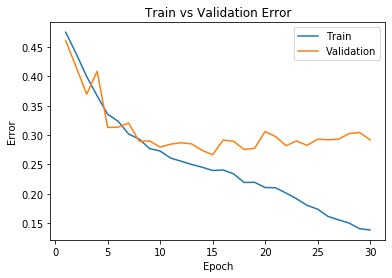

Data: ./partd-large_net/model_large_bs64_lr0.01_epoch29, Graph: Epoch VS Error


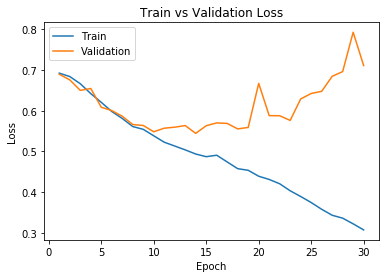

Data: ./partd-large_net/model_large_bs64_lr0.01_epoch29, Graph: Epoch VS Loss


In [6]:
plot_training_curve("./partd-large_net/model_large_bs64_lr0.01_epoch29")

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [10]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()

# Train model
train_net(large_net, trial_name="3_parta_large_net", learning_rate=0.001)



Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360033035278 |Validation err: 0.467, Validation loss: 0.6924686636775732
Epoch 2: Train err: 0.448625, Train loss: 0.6922589735984802 |Validation err: 0.4305, Validation loss: 0.6916493605822325
Epoch 3: Train err: 0.43575, Train loss: 0.6916067395210266 |Validation err: 0.4285, Validation loss: 0.6908544525504112
Epoch 4: Train err: 0.430125, Train loss: 0.690861349105835 |Validation err: 0.424, Validation loss: 0.6896593309938908
Epoch 5: Train err: 0.434125, Train loss: 0.6899196438789368 |Validation err: 0.4195, Validation loss: 0.6886938586831093
Epoch 6: Train err: 0.43575, Train loss: 0.6887414302825928 |Validation err: 0.4195, Validation loss: 0.6867825873196125
Epoch 7: Train err: 0.436875, Train loss: 0.6873775324821472 |Validation err: 0.4185, Validation loss: 0.6851982772350311
Epoch 8: Train err: 0.4375, Train loss: 0.6859276995658875 |Validation err: 

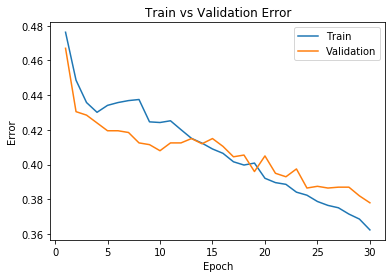

Data: ./3_parta_large_net/model_large_bs64_lr0.001_epoch29, Graph: Epoch VS Error


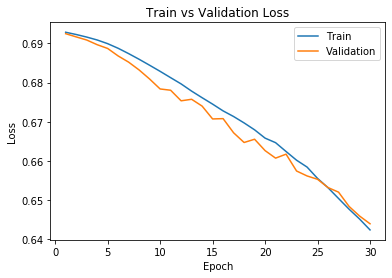

Data: ./3_parta_large_net/model_large_bs64_lr0.001_epoch29, Graph: Epoch VS Loss


In [13]:
plot_training_curve("./3_parta_large_net/model_large_bs64_lr0.001_epoch29")

## Results from learning_rate = 0.001
- Processing time shorter: 
    - learning_rate=0.001 : 103.32 sec
    - learning_rate=0.01 : 101.35 sec
    - Smaller step size results in longer processing time.
    
- Effects of lowering the learning curve:
    - If you do a comparison by comparing the loss and error values per epoch for the learning_rate=0.001 and learning_rate=0.01 graphs, you can see that the loss and error values are lower for training sets in the case where learning_rate=0.01.
    - For the case where learning_rate=0.001, we avoid overfitting our model especially at higher epochs compared to the results when learning_rate=0.01. You can notice that the error results remain similar for training and validation datasets.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [9]:
large_net = LargeNet() # Reset the weights
train_net(large_net, trial_name="3_partb_large_net", learning_rate=0.1)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.450375, Train loss: 0.6837454648017883 |Validation err: 0.4045, Validation loss: 0.6719825621694326
Epoch 2: Train err: 0.38175, Train loss: 0.6471678314208984 |Validation err: 0.37, Validation loss: 0.6361467223614454
Epoch 3: Train err: 0.368375, Train loss: 0.6371797876358032 |Validation err: 0.344, Validation loss: 0.6113323718309402
Epoch 4: Train err: 0.344875, Train loss: 0.61855464220047 |Validation err: 0.333, Validation loss: 0.6108698807656765
Epoch 5: Train err: 0.325875, Train loss: 0.6002723095417023 |Validation err: 0.358, Validation loss: 0.6163406725972891
Epoch 6: Train err: 0.315375, Train loss: 0.5838034338951111 |Validation err: 0.3215, Validation loss: 0.6080240216106176
Epoch 7: Train err: 0.3075, Train loss: 0.5754997911453247 |Validation err: 0.336, Validation loss: 0.5989525923505425
Epoch 8: Train err: 0.289875, Train loss: 0.5637295346260071 |Validation err: 0.3

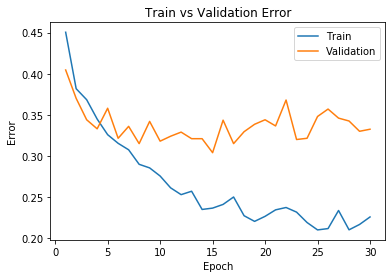

Data: ./3_partb_large_net/model_large_bs64_lr0.1_epoch29, Graph: Epoch VS Error


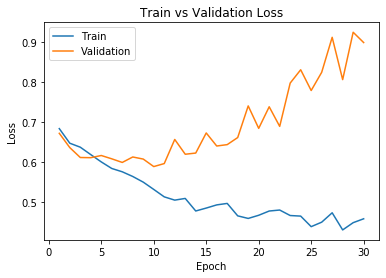

Data: ./3_partb_large_net/model_large_bs64_lr0.1_epoch29, Graph: Epoch VS Loss


In [14]:
plot_training_curve("./3_partb_large_net/model_large_bs64_lr0.1_epoch29")

## Results from learning_rate = 0.1
- Processing time shorter: 
    - learning_rate=0.001 : 103.32 sec
    - learning_rate=0.01 : 101.35 sec
    - learning_rate=0.1 : 104.91 sec
    - Larger step sizes should make the processing time shorter. This goes against the result of 104.91 sec.
    
- Increasing the step sizes results in more variabilty of our error and loss results (I refer to the "smoothness" of the graphs).
- Note how there is an increase in loss as epochs increase compared to previous trials with lower learning rates. This must be a result of less frequent weight tunings that happens as we increase the step size/learning rate.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

In [15]:
large_net = LargeNet() # Reset the weights
train_net(large_net, trial_name="3_partc_large_net", learning_rate=0.01, batch_size=512)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379440844059 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103908240795 |Validation err: 0.434, Validation loss: 0.6917425096035004
Epoch 3: Train err: 0.437, Train loss: 0.6916500441730022 |Validation err: 0.4265, Validation loss: 0.6909130066633224
Epoch 4: Train err: 0.433625, Train loss: 0.6908450089395046 |Validation err: 0.424, Validation loss: 0.6897870898246765
Epoch 5: Train err: 0.434, Train loss: 0.6896936222910881 |Validation err: 0.424, Validation loss: 0.6881358474493027
Epoch 6: Train err: 0.43825, Train loss: 0.6883534342050552 |Validation err: 0.428, Validation loss: 0.6860133558511734
Epoch 7: Train err: 0.43925, Train loss: 0.6866873614490032 |Validation err: 0.426, Validation loss: 0.683697521686554
Epoch 8: Train err: 0.435375, Train loss: 0.6849774271249771 |Validation err: 0.412, V

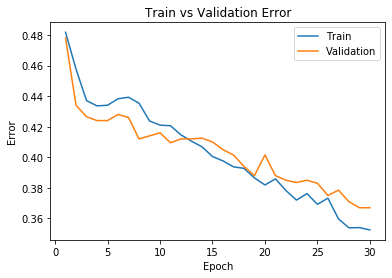

Data: ./3_partc_large_net/model_large_bs512_lr0.01_epoch29, Graph: Epoch VS Error


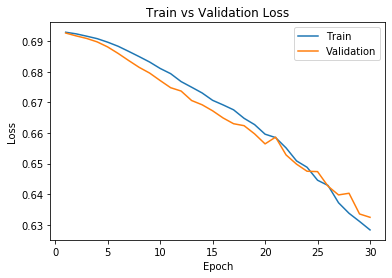

Data: ./3_partc_large_net/model_large_bs512_lr0.01_epoch29, Graph: Epoch VS Loss


In [16]:
plot_training_curve("./3_partc_large_net/model_large_bs512_lr0.01_epoch29")

## Results from learning_rate = 0.01, batch_size = 512
- Processing time shorter: 
    - learning_rate=0.001 : 103.32 sec
    - learning_rate=0.01 : 101.35 sec
    - learning_rate=0.1 : 104.91 sec
    - learning_rate = 0.01, batch_size = 512 : 99.03 sec
    - **Increasing the batch size reduced the processing time.**
    
- With this configuration we were able to generate a model that didn't overfit the training data, with a fast processing time. 

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

In [17]:
large_net = LargeNet() # Reset the weights
train_net(large_net, trial_name="3_partd_large_net", learning_rate=0.01, batch_size=16)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.432625, Train loss: 0.6776098012924194 |Validation err: 0.3745, Validation loss: 0.6529261765480041
Epoch 2: Train err: 0.36725, Train loss: 0.6403517408370971 |Validation err: 0.3495, Validation loss: 0.6183474545478821
Epoch 3: Train err: 0.339875, Train loss: 0.6120943225622177 |Validation err: 0.3435, Validation loss: 0.6299470119476318
Epoch 4: Train err: 0.31125, Train loss: 0.5856365796327591 |Validation err: 0.3285, Validation loss: 0.5919316556453705
Epoch 5: Train err: 0.302875, Train loss: 0.5643226696252823 |Validation err: 0.307, Validation loss: 0.5747922658920288
Epoch 6: Train err: 0.287, Train loss: 0.5471984240412712 |Validation err: 0.3055, Validation loss: 0.5829895379543304
Epoch 7: Train err: 0.267625, Train loss: 0.5227082212567329 |Validation err: 0.292, Validation loss: 0.5768387908935547
Epoch 8: Train err: 0.256375, Train loss: 0.5061253272891044 |Validation err:

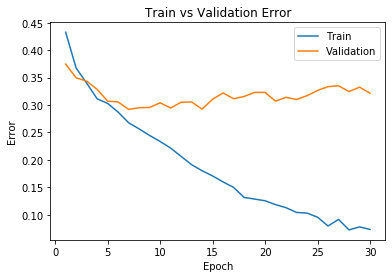

Data: ./3_partd_large_net/model_large_bs16_lr0.01_epoch29, Graph: Epoch VS Error


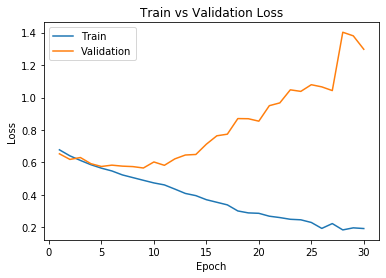

Data: ./3_partd_large_net/model_large_bs16_lr0.01_epoch29, Graph: Epoch VS Loss


In [18]:
plot_training_curve("./3_partd_large_net/model_large_bs16_lr0.01_epoch29")

## Results from learning_rate = 0.01, batch_size = 16
- Processing time shorter: 
    - learning_rate=0.001 : 103.32 sec
    - learning_rate=0.01 : 101.35 sec
    - learning_rate=0.1 : 104.91 sec
    - learning_rate = 0.01, batch_size = 512 : 99.03 sec
    - learning_rate = 0.01, batch_size = 16 : 93.31 sec
    - The processing time was the fastest, but from my understanding I expected the processing time to be lower for larger batch sizes since we iterate through more training samples per optimization step.
    
- By decreasing the batch size, our model was over fit as a result. This is demonstrated by the low error values for the training set compared to the high error values of the validation set. 

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [7]:
large_net = LargeNet() # Reset the weights
train_net(large_net, trial_name="4_parta_large_net", learning_rate=0.001, batch_size=16)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.497625, Train loss: 0.6936436535120011 |Validation err: 0.5055, Validation loss: 0.6928521757125854
Epoch 2: Train err: 0.448625, Train loss: 0.6917455492019653 |Validation err: 0.426, Validation loss: 0.6908736891746521
Epoch 3: Train err: 0.423875, Train loss: 0.6888608788251877 |Validation err: 0.4145, Validation loss: 0.6855896668434143
Epoch 4: Train err: 0.431375, Train loss: 0.6821846729516983 |Validation err: 0.4245, Validation loss: 0.676330235004425
Epoch 5: Train err: 0.415625, Train loss: 0.6736297376155853 |Validation err: 0.4015, Validation loss: 0.6682328958511352
Epoch 6: Train err: 0.390125, Train loss: 0.66201484811306 |Validation err: 0.382, Validation loss: 0.6565566635131836
Epoch 7: Train err: 0.369375, Train loss: 0.649661308169365 |Validation err: 0.372, Validation loss: 0.6460209856033325
Epoch 8: Train err: 0.361, Train loss: 0.6375700086951256 |Validation err: 0.

# NOTE: Kernel kept dying 

Jupyter notebook kernel kept dying as I created trials with smaller batch sizes (ex. 1), and lower learning rates (ex. 0.001). So for now this config will have to do: 
- Epoch: 30
- Learning rate: 0.001
- Batch size: 16

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

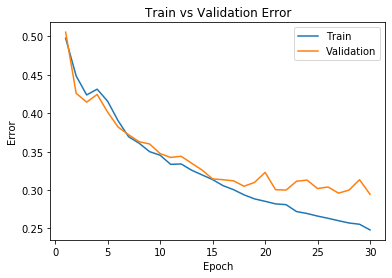

Data: ./4_parta_large_net/model_large_bs16_lr0.001_epoch29, Graph: Epoch VS Error


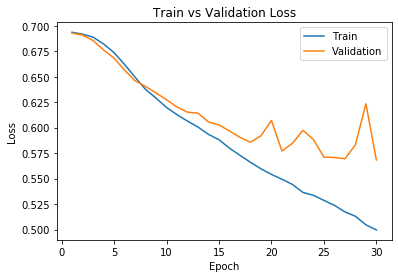

Data: ./4_parta_large_net/model_large_bs16_lr0.001_epoch29, Graph: Epoch VS Loss


In [8]:
plot_training_curve("./4_parta_large_net/model_large_bs16_lr0.001_epoch29")

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

# NOTE: Kernel kept dying

This is a repeat occurence as I developped my code locally (I work fulltime so I have to work on this on the road). 
`[I 12:44:43.930 NotebookApp] KernelRestarter: restarting kernel (1/5), keep random ports`

So for the second run I used the following hyperparameters:
- num_epochs: 50
- learning_rate: 0.001
- batch_size: 16

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [ ]:
large_net = LargeNet() # Reset the weights
train_net(large_net, trial_name="4_partd_large_net", num_epochs = 50, learning_rate=0.001, batch_size=16)
plot_training_curve("./4_partd_large_net/model_large_bs16_lr0.001_epoch49")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.454875, Train loss: 0.6919687811136246 |Validation err: 0.4335, Validation loss: 0.6896940746307373
Epoch 2: Train err: 0.441875, Train loss: 0.6881972507238389 |Validation err: 0.4155, Validation loss: 0.6840243287086487
Epoch 3: Train err: 0.425, Train loss: 0.6826030143499374 |Validation err: 0.4065, Validation loss: 0.6759179067611695
Epoch 4: Train err: 0.413375, Train loss: 0.6765512552261352 |Validation err: 0.411, Validation loss: 0.6703426704406739
Epoch 5: Train err: 0.402875, Train loss: 0.6707051371335984 |Validation err: 0.405, Validation loss: 0.6636630306243897
Epoch 6: Train err: 0.38875, Train loss: 0.6634994777441025 |Validation err: 0.388, Validation loss: 0.6577977638244629
Epoch 7: Train err: 0.38325, Train loss: 0.6566675343513488 |Validation err: 0.388, Validation loss: 0.6490162963867188
Epoch 8: Train err: 0.3725, Train loss: 0.6456935796141624 |Validation err: 0.3

## Part 5. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

## Model that I'm choosing:
- Architecture: large_net
- Batch size: 16
- Learning rate: 0.001
- Epoch number: 26

In [10]:
net = LargeNet()
#model_path = get_model_name("./4_parta_large_net/model_large", batch_size=16, learning_rate=0.001, epoch=26)
state = torch.load("./4_parta_large_net/model_large_bs16_lr0.001_epoch26")
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

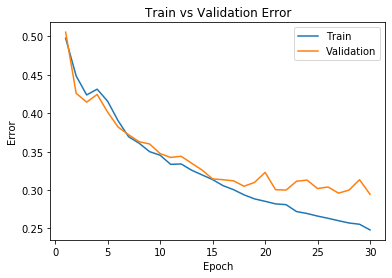

Data: ./4_parta_large_net/model_large_bs16_lr0.001_epoch29, Graph: Epoch VS Error


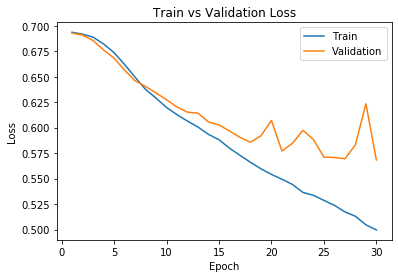

Data: ./4_parta_large_net/model_large_bs16_lr0.001_epoch29, Graph: Epoch VS Loss


In [11]:
plot_training_curve("./4_parta_large_net/model_large_bs16_lr0.001_epoch29")

- At around 26 epoch, the error and loss values for the validation set are at their minimum. At larger epochs, the loss increases which also results in an increase in error.
- Lower batch sizes allow for lower learning rates, which helps the model refine it's weights better. You can see how that results in a smooth decline in error rates for the training set as the number of epochs increases.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [18]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=16)

criterion = nn.BCEWithLogitsLoss()
val_err, val_loss = evaluate(net, val_loader, criterion)
test_err, test_loss = evaluate(net, test_loader, criterion)

print("Validation set - Error: {}, Loss: {}".format(val_err, val_loss))
print("Test set - Error: {}, Loss: {}".format(test_err, test_loss))

Files already downloaded and verified
Files already downloaded and verified
Validation set - Error: 0.296, Loss: 0.569472021818161
Test set - Error: 0.3005, Loss: 0.5615601580142975


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

Test error is greater than validation error. We would expect the test error to be greater than the validation error because:

1. Validation set is used after the training set to fine tune the parameters and to make sanity checks for our model. So the model has been exposed to this dataset.
2. Test set is never before seen data that is withheld from the model until the last test. Therefore, it is to be expected that the validation test results will be lower since the model has already tuned some of it's parameters to handle those cases. Where as, there is more uncertainty when the model processes data that it sees for the first time. 

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

This provides us with an unbiased review of the model's performance. By testing it on never before seen data, we can also gauge whether our model has been overfit/underfit to our training and validation data. 

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [20]:
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim
import numpy as np
import os

torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.layer1 = nn.Linear(32 * 32 * 3, 30)
        self.layer2 = nn.Linear(30, 1)
        self.name = "ANN"
    def forward(self, img):
        flattened = img.view(-1, 32 * 32 * 3)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2.squeeze(1)

pigeon = Pigeon()

train_net(pigeon, batch_size=64, learning_rate=0.001, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.42475, Train loss: 0.6759457721710205 |Validation err: 0.406, Validation loss: 0.6638848315924406
Epoch 2: Train err: 0.394125, Train loss: 0.6592916774749756 |Validation err: 0.3925, Validation loss: 0.6569973006844521
Epoch 3: Train err: 0.385125, Train loss: 0.651371868133545 |Validation err: 0.396, Validation loss: 0.6532590091228485
Epoch 4: Train err: 0.37675, Train loss: 0.6452622833251953 |Validation err: 0.3925, Validation loss: 0.6518572960048914
Epoch 5: Train err: 0.370875, Train loss: 0.6406266741752624 |Validation err: 0.3825, Validation loss: 0.6496040783822536
Epoch 6: Train err: 0.36225, Train loss: 0.6354400963783264 |Validation err: 0.3825, Validation loss: 0.6480690129101276
Epoch 7: Train err: 0.360375, Train loss: 0.6316920895576477 |Validation err: 0.381, Validation loss: 0.6474323458969593
Epoch 8: Train err: 0.3545, Train loss: 0.627733705997467 |Validation err: 0.

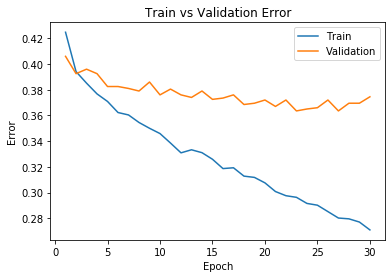

Data: model_ANN_bs64_lr0.001_epoch29, Graph: Epoch VS Error


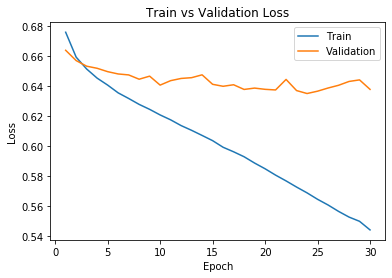

Data: model_ANN_bs64_lr0.001_epoch29, Graph: Epoch VS Loss
Files already downloaded and verified
Files already downloaded and verified
Validation set - Error: 0.3745, Loss: 0.6459474768489599
Test set - Error: 0.3585, Loss: 0.6383772101253271


In [22]:
plot_training_curve("model_ANN_bs64_lr0.001_epoch29")

train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)

criterion = nn.BCEWithLogitsLoss()
val_err, val_loss = evaluate(pigeon, val_loader, criterion)
test_err, test_loss = evaluate(pigeon, test_loader, criterion)

print("Validation set - Error: {}, Loss: {}".format(val_err, val_loss))
print("Test set - Error: {}, Loss: {}".format(test_err, test_loss))

## My CNN architecture compared to ANN results:

### CNN:

1. Validation set:
    - Error: 0.296 
    - Loss: 0.569472021818161
2. Test set: 
    - Error: 0.3005
    - Loss: 0.5615601580142975

### ANN:
1. Validation set:
    - Error: 0.3745
    - Loss: 0.6459474768489599
2. Test set:
    - Error: 0.3585
    - Loss: 0.6383772101253271

As you can see, applying convolutions to our image datasets results in lower error values in our test set, such that CNN resulted in an error of 0.3005 and ANN resulted in an error of 0.3585.

This goes to show that there applying CNNs to image classification problems can provide more accurate results.